In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
import torch
from torch import nn, optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
import collections
import torch.utils.data as data_utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
torch.__version__

'1.9.0+cu111'

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear_layers = nn.Sequential(
                        nn.Linear(111,50),
                        nn.ReLU(),
                        nn.Dropout(p=0.2),
                        nn.Linear(50,20),
                        nn.ReLU(),
                        nn.Dropout(p=0.4),
                        nn.Linear(20,10),
                        nn.ReLU(),
                        nn.Dropout(p=0.4),
                        nn.Linear(10,2)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.linear_layers(x)
        return x

In [7]:
model = Net()
model.load_state_dict(torch.load("/content/drive/MyDrive/FIGA/model_FIGA_trained.pt"))

<All keys matched successfully>

###Original Dataset and model training

In [ ]:
# Reading Original Dataset
data = pd.read_csv("/content/drive/MyDrive/FIGA/dataset_full.csv")

In [ ]:
data = data.sample(frac=1).reset_index(drop=True)
data

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,qty_tilde_url,qty_comma_url,qty_plus_url,qty_asterisk_url,qty_hashtag_url,qty_dollar_url,qty_percent_url,qty_tld_url,length_url,qty_dot_domain,qty_hyphen_domain,qty_underline_domain,qty_slash_domain,qty_questionmark_domain,qty_equal_domain,qty_at_domain,qty_and_domain,qty_exclamation_domain,qty_space_domain,qty_tilde_domain,qty_comma_domain,qty_plus_domain,qty_asterisk_domain,qty_hashtag_domain,qty_dollar_domain,qty_percent_domain,qty_vowels_domain,domain_length,domain_in_ip,server_client_domain,...,qty_hashtag_file,qty_dollar_file,qty_percent_file,file_length,qty_dot_params,qty_hyphen_params,qty_underline_params,qty_slash_params,qty_questionmark_params,qty_equal_params,qty_at_params,qty_and_params,qty_exclamation_params,qty_space_params,qty_tilde_params,qty_comma_params,qty_plus_params,qty_asterisk_params,qty_hashtag_params,qty_dollar_params,qty_percent_params,params_length,tld_present_params,qty_params,email_in_url,time_response,domain_spf,asn_ip,time_domain_activation,time_domain_expiration,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,15,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,15,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,1.192402,0,-1,-1,-1,1,5,3,291,1,1,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,9,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,3.263408,1,14987,7959,439,1,2,5,3586,0,0,0,0,0,0
2,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,17,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,16,0,0,...,0,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,-1.000000,0,-1,28,336,-1,2,0,-1,0,-1,0,0,0,1
3,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,20,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,19,0,0,...,0,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0.207433,0,13335,3158,128,2,2,2,299,1,0,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,28,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,28,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0.555495,0,-1,-1,-1,1,2,1,298,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88642,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,18,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,18,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0.344092,0,53831,6708,961,1,2,1,599,1,0,0,0,0,0
88643,1,0,2,2,0,2,0,1,0,0,0,0,0,0,0,0,0,1,62,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,12,0,0,...,0,0,0,5,0,0,2,0,0,2,0,1,0,0,0,0,0,0,0,0,0,42,0,2,0,0.654480,1,262254,169,195,1,3,7,596,1,0,0,0,0,1
88644,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,24,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,23,0,0,...,0,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0.679906,0,24638,-1,-1,1,2,1,592,1,0,0,0,0,0
88645,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,16,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,16,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,-1.000000,0,-1,-1,-1,-1,4,0,-1,0,-1,0,0,0,0


In [ ]:
#Scaling the data
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

df_scaled

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,qty_tilde_url,qty_comma_url,qty_plus_url,qty_asterisk_url,qty_hashtag_url,qty_dollar_url,qty_percent_url,qty_tld_url,length_url,qty_dot_domain,qty_hyphen_domain,qty_underline_domain,qty_slash_domain,qty_questionmark_domain,qty_equal_domain,qty_at_domain,qty_and_domain,qty_exclamation_domain,qty_space_domain,qty_tilde_domain,qty_comma_domain,qty_plus_domain,qty_asterisk_domain,qty_hashtag_domain,qty_dollar_domain,qty_percent_domain,qty_vowels_domain,domain_length,domain_in_ip,server_client_domain,...,qty_hashtag_file,qty_dollar_file,qty_percent_file,file_length,qty_dot_params,qty_hyphen_params,qty_underline_params,qty_slash_params,qty_questionmark_params,qty_equal_params,qty_at_params,qty_and_params,qty_exclamation_params,qty_space_params,qty_tilde_params,qty_comma_params,qty_plus_params,qty_asterisk_params,qty_hashtag_params,qty_dollar_params,qty_percent_params,params_length,tld_present_params,qty_params,email_in_url,time_response,domain_spf,asn_ip,time_domain_activation,time_domain_expiration,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.333333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,-0.375,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.145949,0.0,-0.927132,-0.474315,-0.476056,0.0,1.5,2.0,-0.165429,0.0,1.0,0.0,0.0,0.0,0.0
1,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.619048,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.666667,-1.125,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.415318,1.0,-0.232825,0.764788,0.763380,0.0,0.0,4.0,0.148201,-1.0,0.0,0.0,0.0,0.0,0.0
2,-1.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.238095,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,-0.250,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.315060,0.0,-0.927132,-0.469801,0.473239,-2.0,0.0,-1.0,-0.193223,-1.0,-1.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.095238,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.125,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.408960,0.0,-0.309353,0.017435,-0.112676,1.0,0.0,1.0,-0.164668,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.285714,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.000000,1.250,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.140504,0.0,-0.927132,-0.474315,-0.476056,0.0,0.0,0.0,-0.164763,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88642,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.190476,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.193225,0.0,1.566591,0.570050,2.233803,0.0,0.0,0.0,-0.136113,0.0,0.0,0.0,0.0,0.0,0.0
88643,-1.0,0.0,2.0,1.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.904762,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [ ]:
#Changing Target label type from float(Caused by scaling) to int
df_scaled['phishing'] = df_scaled['phishing'].astype(int)

In [ ]:
train_data = df_scaled.iloc[:int(88647*0.8)]
val_data = df_scaled.iloc[int(88647*0.8):int(88647*0.8)+int(11055*0.1)]
test_data = df_scaled.iloc[int(88647*0.8)+int(88647*0.1):]

In [ ]:
#Creating Dataloaders
train_target = torch.from_numpy(train_data['phishing'].values)
train = torch.from_numpy(train_data.drop('phishing', axis = 1).values,).float()
train_tensor = data_utils.TensorDataset(train, train_target)
train_loader = data_utils.DataLoader(dataset = train_tensor, batch_size = 128, shuffle = True)

train_target = torch.from_numpy(val_data['phishing'].values)
train = torch.from_numpy(val_data.drop('phishing', axis = 1).values).float()
train_tensor = data_utils.TensorDataset(train, train_target) 
valid_loader = data_utils.DataLoader(dataset = train_tensor, batch_size = 128, shuffle = True)

train_target = torch.from_numpy(test_data['phishing'].values)
train = torch.from_numpy(test_data.drop('phishing', axis = 1).values).float()
train_tensor = data_utils.TensorDataset(train, train_target) 
test_loader = data_utils.DataLoader(dataset = train_tensor, batch_size = 128, shuffle = True)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
model = Net()
model.to(device)

Net(
  (linear_layers): Sequential(
    (0): Linear(in_features=111, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=50, out_features=20, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=20, out_features=10, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.4, inplace=False)
    (9): Linear(in_features=10, out_features=2, bias=True)
  )
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer  = optim.Adam(model.parameters(),lr = 1e-3)
scheduler = StepLR(optimizer, step_size=8, gamma=0.35) #Learning Rate Scheduler

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/FIGA/model_normal.pt"))

<All keys matched successfully>

In [ ]:
#TRAINING

epochs = 40 # Number of epochs
steps = 0
print_every = 10 
train_losses, valid_losses,valid_acc = [], [], [] # List keeping track of losses and accuracy to plot later
valid_loss_min = np.Inf # It will be used to save model whenever Vallidation loss decreases
valid_acc_min = 0.0 

for e in range(epochs):
  
  train_loss = 0 
  model.train()
  #train the model
  for data, labels in train_loader:
    steps+=1
    # Move tensor to device('cuda' in case of GPU or 'cpu' in case of CPU)
    data, labels = data.to(device), labels.to(device)
    # Clearing all the previous gradients
    optimizer.zero_grad()
    # Forward Pass
    logits = model(data)
    # Loss calculation
    loss = criterion(logits,labels)
    # Backward Pass
    loss.backward()
    # Update the parameters
    optimizer.step()
    # Updating the losses list
    train_loss += loss.item()

    # Evaluating after specific amount of steps
    if steps % print_every == 0:
      valid_loss = 0
      accuracy = 0
      # Setting Model to Evaluation Mode
      model.eval()
      with torch.no_grad():
        # Getting Validation loss
        for data, labels in valid_loader:
          data, labels = data.to(device), labels.to(device)
          logits = model(data)
          batch_loss = criterion(logits,labels)
          valid_loss += batch_loss.item()
          
          # Calculating Accuracy
          output = F.softmax(logits,dim=1)
          top_p,top_class = output.topk(1,dim = 1)
          equals = top_class == labels.view(*top_class.shape)
          accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
      # Printing stats    
      print(f"Epoch {e+1}/{epochs}.. "
                  f"Train loss: {train_loss/print_every:.3f}.. "
                  f"Validation loss: {valid_loss/len(valid_loader):.3f}.. "
                  f"Validation accuracy: {accuracy/len(valid_loader):.3f}.. "
                  f"LR : {scheduler.get_lr():}"
                  )
      valid_loss = valid_loss/len(valid_loader)
      train_losses.append(train_loss/print_every)
      valid_losses.append(valid_loss)
      valid_acc.append(accuracy/len(valid_loader))
      
      # Checking if Validation loss decreased
      if valid_loss <= valid_loss_min:
        
        # if decreased, it will save the model
        print('valid loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss
      
      
  # Scheduler performing a step to change learning rate of Optimizer    
  scheduler.step()

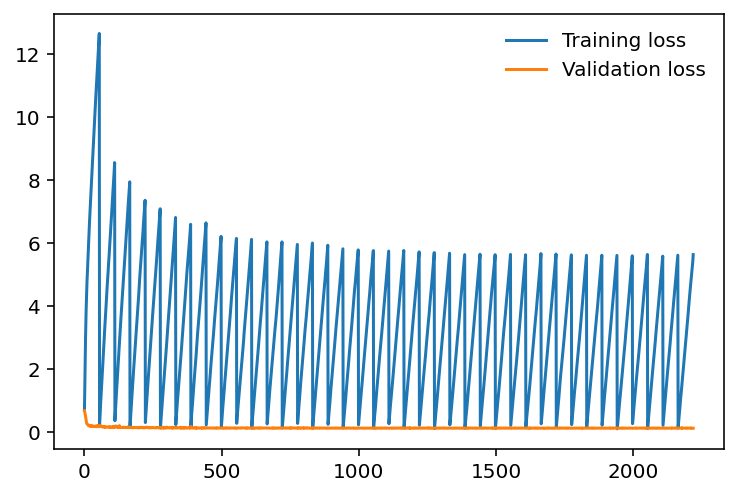

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)

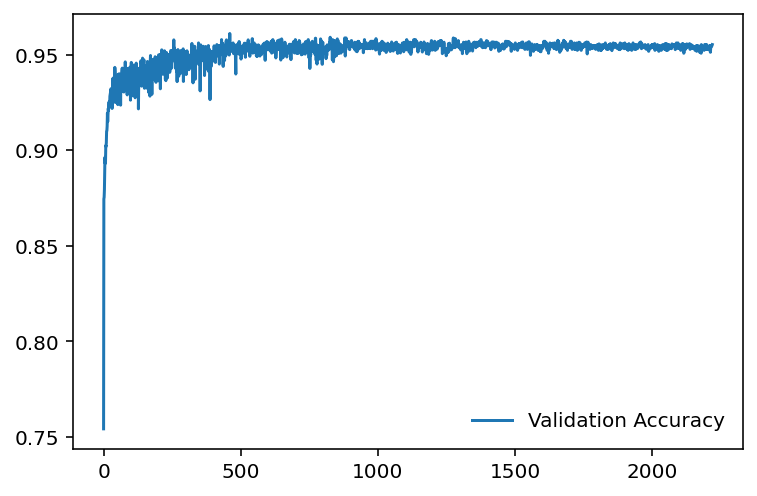

In [ ]:
plt.plot(valid_acc, label='Validation Accuracy')
plt.legend(frameon=False)

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/FIGA/model_normal.pt')

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/FIGA/model_normal.pt"))

<All keys matched successfully>

In [ ]:
#To measure accuracy

def measure_accuracy(test_loader):
  model.eval() # Prep model for Evaluation
  correct_total = 0.
  total = 0.

  mean_of = 5 # Mean of how many evaluations
  valid_loss = 0.0

  for i in range(mean_of):
    for data, target in test_loader:
      # Move the data to device
      data, target = data.to(device), target.to(device)
      # forward pass: compute predicted outputs by passing inputs to the model
      output = model(data)
      # calculate the loss
      loss = criterion(output, target)
      # update test loss 
      valid_loss += loss.item()*data.size(0)
      # convert output probabilities to predicted class
      _, pred = torch.max(output, 1)
      # compare predictions to true label
      correct = np.squeeze(pred.eq(target.data.view_as(pred)))
      for i in range(len(target)):
        if len(target) == 1:
          correct_total += correct.item()
        else:
          correct_total += correct[i].item()
        total += 1

  # calculate and print average test loss
  valid_loss = valid_loss/(mean_of * len(test_loader.dataset))
  print('Test Loss: {:.6f}\n'.format(valid_loss))


  #print total accuracy of the model
  print('Test Accuracy (Overall): %0.2f%% (%2d/%2d)' % (
      (correct_total/total)*100,
      np.sum(correct_total), np.sum(total)))

In [ ]:
#Normal Samples Accuracy (test_loader is the loader from original data)
measure_accuracy(test_loader)

Test Loss: 0.088739

Test Accuracy (Overall): 96.77% (42900/44330)


In [ ]:
#Perturbating Samples
test_data_new = test_data
X, y = test_data_new.drop('phishing',axis =1 ), test_data_new['phishing']
f, d, scaler = featureImportance(X, y, 40)
for i in range(test_data_new.shape[0]):
  if test_data_new.iloc[i,111] == 1:
    X.iloc[i,:] = perturbation( f, d, X.iloc[i,:].to_numpy(), scaler, e=0.5).ravel()

In [ ]:
#Creating Dataloader of Perturbated samples 
train_target = torch.from_numpy(y.values)
train = torch.from_numpy(X.values).float()
train_tensor = data_utils.TensorDataset(train, train_target) 
test_loader_new = data_utils.DataLoader(dataset = train_tensor, batch_size = 128, shuffle = True)

In [ ]:
#Perturbated Samples Accuracy (test_loader_new is the loader from Perturbated data)
measure_accuracy(test_loader_new)

Test Loss: 7.482518

Test Accuracy (Overall): 63.38% (28095/44330)


##FIGA

###FIGA Implementation

In [8]:
#FIGA IMPLEMENTATION

def check_sign(phis, legi, feature_no):
    '''
    phis - Phishing Site Data
    legi - Legitimate Site Data
    feature_no - The feature for which sign needs to be checked
    '''
    if (phis.iloc[:,feature_no].mean() - legi.iloc[:,feature_no].mean())>=0:
        return -1
    else:
        return 1

def featureImportance(X, y, n):
    '''
    X - Data
    y - Labels
    n - The number of features to perturb
    '''
    dtc = DecisionTreeClassifier()
    dtc.fit(X, y)
    importance = dtc.feature_importances_
    df_impor = pd.DataFrame({'Feature':np.arange(0,importance.size), 'Importance':importance},columns=['Feature', 'Importance'])
    df_impor.sort_values(by=['Importance'], ascending=False,inplace=True)
    f = df_impor.iloc[:n,0]
    phis = X[y==1]
    legi = X[y==0]
    d = [check_sign(phis, legi, x) for x in f]
    scaler = MinMaxScaler()
    scaler.fit(X)
    return f.to_numpy(), d, scaler
    
def perturbation(f, d, x, scaler, e = 0.05):
    '''
    X - Data
    f - feature_importance; A ranked feature vector
    d - Signed attack direction vector
    x - Sample to be perturbated
    scaler - Scaler used to transform values
    e - The total percentage of the input to modify
    '''
    sample = x
    sample = scaler.transform(sample.reshape(1, -1))
    E = e*np.sum(sample)/f.size
    for i in range(f.size):
        temp = sample[0][f[i]] + (E*d[i])
        if temp<0:
            temp = 0
        sample[0][f[i]] = temp
    sample = scaler.inverse_transform(sample)
    return np.round_(sample)

###Training Model with perturbated dataset

In [ ]:
#Creating new dataset with perturbated samples with different combinations of n and e

data = pd.read_csv("/content/drive/MyDrive/FIGA/dataset_full.csv")
total_data = data
for n_f, e in [(20,0.6),(40,0.3),(30,0.7)]:
  data_to_perturb = data
  data_to_perturb = new_data.sample(frac=1).reset_index(drop=True)
  data_to_perturb = data_to_perturb.iloc[:int(data.shape[0]*0.3),:]
  X, y = data_to_perturb.drop('phishing', axis = 1 ), data_to_perturb['phishing']
  f, d, scaler = featureImportance(X, y , n_f)
  for i in range(X.shape[0]):
    if y.iloc[i] == 1:
      X.iloc[i,:] = perturbation( f, d, X.iloc[i,:].to_numpy(), scaler, e).ravel()
  X['phishing'] = y
  total_data = total_data.append(X)
  del data_to_perturb

In [ ]:
#Saving the new dataset
total_data.to_csv('/content/drive/MyDrive/FIGA/dataset_full_new.csv',index=False)

In [ ]:
total_data = pd.read_csv("/content/drive/MyDrive/FIGA/dataset_full_new.csv", index_col=False)

In [ ]:
total_data

In [ ]:
dataset_length = total_data.shape[0]

In [ ]:
#Scaling the new dataset
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(total_data.drop('phishing', axis = 1)), columns=total_data.drop('phishing', axis = 1).columns)

df_scaled['phishing'] = total_data['phishing']

In [ ]:
#Saving Sampler Pickle File 
import pickle
scalerfile = '/content/drive/MyDrive/FIGA/scaler.pkl'
pickle.dump(scaler, open(scalerfile, 'wb'))

In [ ]:
#Saving Model pickle file
import pickle
modelfile = '/content/drive/MyDrive/FIGA/model_FIGA_Trained.pkl'
pickle.dump(model, open(modelfile, 'wb'))

In [ ]:
import pickle
scalerfile = '/content/drive/MyDrive/FIGA/scaler.pkl'
scaler = pickle.load(open(scalerfile, 'rb'))
modelfile = '/content/drive/MyDrive/FIGA/model_FIGA_Trained.pkl'
model = pickle.load(open(modelfile, 'rb'))

In [ ]:
df_scaled

In [ ]:
a = torch.tensor(scaler.transform(np.array(total_data.iloc[4,:111]).reshape(1,-1)).ravel())

In [ ]:
output = model(a.float().unsqueeze(0))
_, pred = torch.max(output, 1)
print(pred.item())

In [ ]:
df_scaled.shape

In [ ]:
#Creating DataLoader of the new dataset
train_data = df_scaled.iloc[:int(dataset_length*0.8)]
val_data = df_scaled.iloc[int(dataset_length*0.8):int(dataset_length*0.9)]
test_data = df_scaled.iloc[int(dataset_length*0.9):]

train_target = torch.from_numpy(train_data['phishing'].values)
train = torch.from_numpy(train_data.drop('phishing', axis = 1).values,).float()
train_tensor = data_utils.TensorDataset(train, train_target)
train_loader = data_utils.DataLoader(dataset = train_tensor, batch_size = 128, shuffle = True)

train_target = torch.from_numpy(val_data['phishing'].values)
train = torch.from_numpy(val_data.drop('phishing', axis = 1).values).float()
train_tensor = data_utils.TensorDataset(train, train_target) 
valid_loader = data_utils.DataLoader(dataset = train_tensor, batch_size = 128, shuffle = True)

train_target = torch.from_numpy(test_data['phishing'].values)
train = torch.from_numpy(test_data.drop('phishing', axis = 1).values).float()
train_tensor = data_utils.TensorDataset(train, train_target) 
test_loader = data_utils.DataLoader(dataset = train_tensor, batch_size = 128, shuffle = True)

In [ ]:
data, labels = next(iter(train_loader))

In [ ]:
data.shape

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

model = Net()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer  = optim.Adam(model.parameters(),lr = 1e-3)
scheduler = StepLR(optimizer, step_size=8, gamma=0.35)

In [ ]:
#TRAINING MODEL ON NEW DATASET

epochs = 40 # Number of epochs
steps = 0
print_every = 10 
train_losses, valid_losses,valid_acc = [], [], [] # List keeping track of losses and accuracy to plot later
valid_loss_min = np.Inf # It will be used to save model whenever Vallidation loss decreases
valid_acc_min = 0.0 

for e in range(epochs):
  
  train_loss = 0 
  model.train()
  #train the model
  for data, labels in train_loader:
    steps+=1
    # Move tensor to device('cuda' in case of GPU or 'cpu' in case of CPU)
    data, labels = data.to(device), labels.to(device)
    # Clearing all the previous gradients
    optimizer.zero_grad()
    # Forward Pass
    logits = model(data)
    # Loss calculation
    loss = criterion(logits,labels)
    # Backward Pass
    loss.backward()
    # Update the parameters
    optimizer.step()
    # Updating the losses list
    train_loss += loss.item()

    # Evaluating after specific amount of steps
    if steps % print_every == 0:
      valid_loss = 0
      accuracy = 0
      # Setting Model to Evaluation Mode
      model.eval()
      with torch.no_grad():
        # Getting Validation loss
        for data, labels in valid_loader:
          data, labels = data.to(device), labels.to(device)
          logits = model(data)
          batch_loss = criterion(logits,labels)
          valid_loss += batch_loss.item()
          
          # Calculating Accuracy
          output = F.softmax(logits,dim=1)
          top_p,top_class = output.topk(1,dim = 1)
          equals = top_class == labels.view(*top_class.shape)
          accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
      # Printing stats    
      print(f"Epoch {e+1}/{epochs}.. "
                  f"Train loss: {train_loss/print_every:.3f}.. "
                  f"Validation loss: {valid_loss/len(valid_loader):.3f}.. "
                  f"Validation accuracy: {accuracy/len(valid_loader):.3f}.. "
                  f"LR : {scheduler.get_lr():}"
                  )
      valid_loss = valid_loss/len(valid_loader)
      train_losses.append(train_loss/print_every)
      valid_losses.append(valid_loss)
      valid_acc.append(accuracy/len(valid_loader))
      
      # Checking if Validation loss decreased
      if valid_loss <= valid_loss_min:
        
        # if decreased, it will save the model
        print('valid loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss
      
      
  # Scheduler performing a step to change learning rate of Optimizer    
  scheduler.step()

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/FIGA/model_FIGA_trained.pt')
measure_accuracy(test_loader)

###Testing Model trained with perturbated dataset on new n and e

In [ ]:
#Creating a new test dataset with original perturbated values of original data with new n and e (n and e not seen by model)

n_f, e = 20, 0.08
test_data_new = test_data.drop('phishing',axis = 1)
test_data_labels = test_data['phishing']
f, d, scaler = featureImportance(test_data_new, test_data_labels , n_f)
for i in range(test_data_new.shape[0]):
  if test_data_labels.iloc[i]==1:
    test_data_new.iloc[i,:] = perturbation( f, d, test_data_new.iloc[i,:].to_numpy(), scaler, e).ravel()

In [ ]:
#making a testloader out of it

train_target = torch.from_numpy(test_data_labels.values)
train = torch.from_numpy(test_data_new.values).float()
train_tensor = data_utils.TensorDataset(train, train_target) 
test_loader_new = data_utils.DataLoader(dataset = train_tensor, batch_size = 128, shuffle = True)

In [ ]:
#Testing perturbation with new n and e on normal model

model.load_state_dict(torch.load("/content/drive/MyDrive/FIGA/model_normal.pt"))
measure_accuracy(test_loader_new)

In [ ]:
#Testing perturbation with new n and e on Adversarially trained model

model.load_state_dict(torch.load("/content/drive/MyDrive/FIGA/model_FIGA_trained_2.pt"))
measure_accuracy(test_loader_new)

##Inference

In [ ]:
import pickle
import torch
from torch import nn
import numpy as np
import pandas as pd
import collections

In [ ]:
a = np.array([ 2.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
        0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
        0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
        0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
        0.00000e+00,  1.00000e+00,  1.40000e+01,  2.00000e+00,
        0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
        0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
        0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
        0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
        2.00000e+00,  1.40000e+01,  0.00000e+00,  0.00000e+00,
       -1.00000e+00, -1.00000e+00, -1.00000e+00, -1.00000e+00,
       -1.00000e+00, -1.00000e+00, -1.00000e+00, -1.00000e+00,
       -1.00000e+00, -1.00000e+00, -1.00000e+00, -1.00000e+00,
       -1.00000e+00, -1.00000e+00, -1.00000e+00, -1.00000e+00,
       -1.00000e+00, -1.00000e+00, -1.00000e+00, -1.00000e+00,
       -1.00000e+00, -1.00000e+00, -1.00000e+00, -1.00000e+00,
       -1.00000e+00, -1.00000e+00, -1.00000e+00, -1.00000e+00,
       -1.00000e+00, -1.00000e+00, -1.00000e+00, -1.00000e+00,
       -1.00000e+00, -1.00000e+00, -1.00000e+00, -1.00000e+00,
       -1.00000e+00, -1.00000e+00, -1.00000e+00, -1.00000e+00,
       -1.00000e+00, -1.00000e+00, -1.00000e+00, -1.00000e+00,
       -1.00000e+00, -1.00000e+00, -1.00000e+00, -1.00000e+00,
       -1.00000e+00, -1.00000e+00, -1.00000e+00, -1.00000e+00,
       -1.00000e+00, -1.00000e+00, -1.00000e+00, -1.00000e+00,
        0.00000e+00,  6.91094e-01,  1.00000e+00,  1.52440e+04,
        7.09900e+03,  2.05000e+02,  1.00000e+00,  2.00000e+00,
        2.00000e+00,  3.58900e+03,  0.00000e+00,  0.00000e+00,
        0.00000e+00,  0.00000e+00,  0.00000e+00])

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear_layers = nn.Sequential(
                        nn.Linear(111,50),
                        nn.ReLU(),
                        nn.Dropout(p=0.2),
                        nn.Linear(50,20),
                        nn.ReLU(),
                        nn.Dropout(p=0.4),
                        nn.Linear(20,10),
                        nn.ReLU(),
                        nn.Dropout(p=0.4),
                        nn.Linear(10,2)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.linear_layers(x)
        return x


scalerfile = '/content/drive/MyDrive/FIGA/scaler.pkl'
scaler = pickle.load(open(scalerfile, 'rb'))
modelfile = '/content/drive/MyDrive/FIGA/model_FIGA_Trained.pkl'
model = pickle.load(open(modelfile, 'rb'))


In [ ]:
a = torch.tensor(scaler.transform(a.reshape(1,-1)).ravel())

output = model(a.float().unsqueeze(0))
_, pred = torch.max(output, 1)
print(pred.item())

0
